In [129]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [130]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 80

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 2000

# Number of weak classifiers
nbrWeakClassifiers = 100

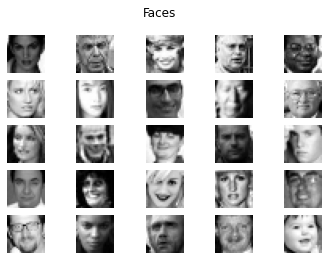

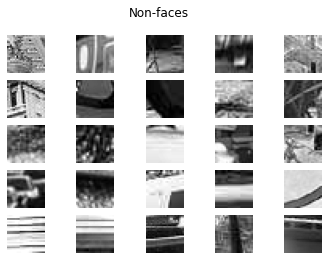

In [131]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

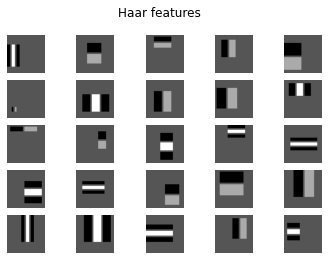

In [132]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [133]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [134]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

D = np.full(nbrTrainImages, (1 / nbrTrainImages))
classifiers = np.zeros((nbrWeakClassifiers, 4))

xTrain = np.transpose(xTrain)
xTest = np.transpose(xTest)

for K in range(nbrWeakClassifiers):
    minError = float('inf')
    
    for feature in range(nbrHaarFeatures):
        thresholds = np.unique(xTrain[:, feature])
        
        for threshold in thresholds:
            P = 1
            C = WeakClassifier(threshold, P, xTrain[:, feature])
            error = WeakClassifierError(C, D, yTrain)
            
            if error > 0.5:
                error = 1 - error
                P = -1
            
            if error < minError:
                classifiers[K,0] = P
                classifiers[K,1] = threshold
                classifiers[K,2] = feature
                minError = error
    alpha = 0.5 * np.log((1.0 - minError) / (minError + 1e-10))
    classifiers[K,3] = alpha
    predictions = WeakClassifier(classifiers[K,1], classifiers[K,0], xTrain[:, np.int64(classifiers[K,2])])
    
    D *= np.exp(-alpha * yTrain * predictions)
    D /= np.sum(D)

In [135]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

pred_train = np.zeros((nbrTrainImages, 1))
pred_test = np.zeros((np.shape(yTest)[0], 1))

for classifier in classifiers:
    C_train = WeakClassifier(classifier[1], classifier[0], xTrain[:, np.int64(classifier[2])])
    C_train = np.expand_dims(C_train, axis = 1)
    
    C_test = WeakClassifier(classifier[1], classifier[0], xTest[:, np.int64(classifier[2])])
    C_test = np.expand_dims(C_test, axis = 1)
    
    pred_train += classifier[3] * C_train
    pred_test += classifier[3] * C_test
pred_train = np.sign(pred_train).flatten()
pred_test = np.sign(pred_test).flatten()

print(sum(pred_train == yTrain) / len(yTrain))
print(sum(pred_test == yTest) / len(yTest))

0.989
0.9441972562106044


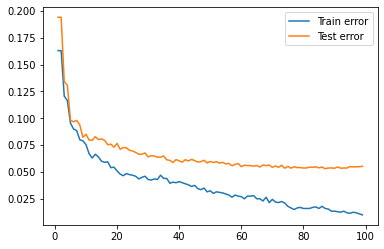

In [136]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

error_mat = np.zeros((nbrWeakClassifiers-1, 3))

for i in range(1,nbrWeakClassifiers):
    pred_train = np.zeros((nbrTrainImages, 1))
    pred_test = np.zeros((np.shape(yTest)[0], 1))
    
    for classifier in classifiers[:i]:
        C_train = WeakClassifier(classifier[1], classifier[0], xTrain[:, np.int64(classifier[2])])
        C_train = np.expand_dims(C_train, axis = 1)
    
        C_test = WeakClassifier(classifier[1], classifier[0], xTest[:, np.int64(classifier[2])])
        C_test = np.expand_dims(C_test, axis = 1)
        
        pred_train += classifier[3] * C_train
        pred_test += classifier[3] * C_test
        
    pred_train = np.sign(pred_train).flatten()
    pred_test = np.sign(pred_test).flatten()
    
    error_mat[i-1,0] = i
    error_mat[i-1,1] = 1 - sum(pred_train == yTrain) / len(yTrain)
    error_mat[i-1,2] = 1 - sum(pred_test == yTest) / len(yTest)

plt.plot(error_mat[:,0], error_mat[:,1], label = 'Train error')
plt.plot(error_mat[:,0], error_mat[:,2], label = 'Test error')
plt.legend()
plt.show()


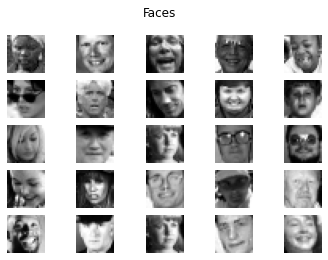

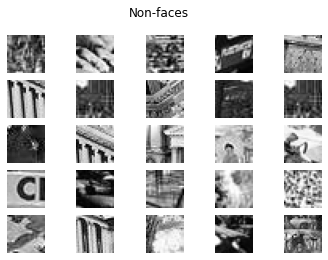

In [140]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.

misclass_faces_ind = [i for i in range(len(pred_test)) if pred_test[i] != yTest[i] and yTest[i] == 1]
misclass_nonfaces_ind = [i for i in range(len(pred_test)) if pred_test[i] != yTest[i] and yTest[i] == -1]

misclass_faces_ind_subset = np.random.choice(misclass_faces_ind, 25)
misclass_nonfaces_ind_subset = np.random.choice(misclass_nonfaces_ind, 25)

plt.figure()
for i in range(len(misclass_faces_ind_subset)):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,misclass_faces_ind_subset[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(len(misclass_faces_ind_subset)):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,misclass_nonfaces_ind_subset[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')

plt.show()


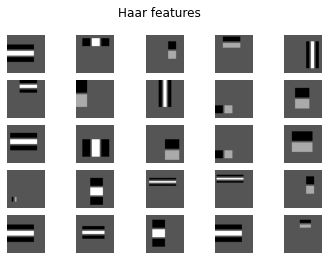

In [138]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.

plt.figure()
for k in range(len(haarFeatureMasks)+1):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,np.int64(classifiers[k,2])], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()